In [1]:
import torch
import h5py
from sklearn.metrics import roc_curve, auc, precision_recall_curve
# import sys
# import subprocess
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
# from torch.distributions import Normal
import numpy as np
# import argparse
import time
import pandas as pd
from helpers import timeSince, asMinutes, calc_auc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from baseline_model import *
from sklearn.metrics import roc_curve, auc, precision_recall_curve

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
expn_pth = '/n/data_02/Basset/data/expn/roadmap/57epigenomes.RPKM.pc'
print("Reading gene expression data from:\n{}".format(expn_pth))
# Gene expression dataset
expn = pd.read_table(expn_pth,header=0)
col_names = expn.columns.values[1:]
expn = expn.drop(col_names[-1],axis=1)
expn.columns = col_names
pinned_lookup = nn.Embedding.from_pretrained(torch.FloatTensor(expn.as_matrix().T),freeze=True)
pinned_lookup.cuda()

Model successfully imported
Total number of parameters 14970901
Reading gene expression data from:
/n/data_02/Basset/data/expn/roadmap/57epigenomes.RPKM.pc


Embedding(57, 19795)

In [52]:
# Prepare Datasets
start = time.time()
data = h5py.File('/n/data_02/Basset/data/roadmap/histone/histone_token.h5')

# Set celltype holdouts
# ['E004','E038','E082','E095','E098','E123','E127'] ['H1 Derived Mesendo','CD4 Naive Primary','Fetal Brain','Left Ventricle','Pancreas','K562','NHEK-Epidermal']
alltypes   = [ str(x, 'utf-8') for x in list(data['target_labels'][:]) ]
holdouts   = ['E004','E038','E082','E095','E098','E123','E127']

train_type = [ x for x in alltypes if x not in holdouts ]
valid_type = ['E004','E095','E098','E127']
test_type  = ['E038','E082','E123']

train = RoadmapDataset(data,expn,train_type,segment='train')
val   = RoadmapDataset(data,expn,valid_type,segment='valid')
test  = RoadmapDataset(data,expn,test_type,segment='test')

# Set Loader
train_loader = torch.utils.data.DataLoader(train, batch_size=2000, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=500, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=500, shuffle=False)

print("Dataloaders generated {}".format( timeSince(start) ))

Dataloaders generated 0m 0s


# Create Dataset and Loader

In [294]:
dataset = RoadmapDataset(data,expn,test_type,segment='test')
loader = torch.utils.data.DataLoader(dataset, batch_size=500, shuffle=False)
len(dataset) # creates n_seq and n_cell attributes

215658

# KNN

In [118]:
knn_model = BassetNorm(output_labels=49)
knn_model.load_state_dict(torch.load('knn_00.pkl'))
knn_model.cuda()
num_params = sum([p.numel() for p in model.parameters()])
print("Model successfully imported\nTotal number of parameters {}".format(num_params))

Model successfully imported
Total number of parameters 14970901


In [240]:
valtestdex = np.concatenate([val.expn_dex,test.expn_dex])
traindex = train.expn_dex
valtestdex = torch.cuda.LongTensor(valtestdex)
traindex = torch.cuda.LongTensor(traindex)
simmat = torch.zeros(7,49).cuda()
mat = pinned_lookup.weight
for i in range(7):
    for j in range(49):
        simmat[i,j] = (mat[valtestdex[i]]-mat[traindex[j]]).pow(2).sum().pow(0.5)
F.cosine_similarity(mat[valtestdex[i]],mat[traindex[j]],dim=0).item()
# simmat = torch.rand(7,49).cuda()

k_weights, k_nearest = simmat.sort(descending=False)
# a,b=k_weights,k_nearest
print(k_weights[:,:10])
num_k=1
k_weights, k_nearest = k_weights[:,:num_k], k_nearest[:,:num_k]
k_weights = F.normalize(k_weights, p=1, dim=1)
tensor1 = torch.zeros(7,49).cuda()
tensor1.scatter_(1, k_nearest, k_weights)
tensor2 = torch.zeros(57,49).cuda()
tensor2[valtestdex,:] = tensor1
# tensor2 = tensor2.cuda()



Columns 0 to 5 
  4813.6943   5158.9629   5319.4961   6279.4995   6450.2236   7060.4541
  8609.6553  23816.9355  23915.2070  24453.2949  24526.6758  24562.6973
 85747.7812  88518.5703  88535.1484  88539.7500  88572.1406  88575.5078
  9963.8594  12513.3994  15241.6162  16684.0527  23506.6191  23561.4883
  1556.2928   3346.5557   6362.0488   6431.6816   7184.9971   7649.5493
  7742.4268   7775.4453   7810.6455   8091.4185   8398.5479   8971.1787
 14230.4404  14515.3301  14581.3896  14888.5098  14974.9307  15014.8135

Columns 6 to 9 
  7439.1616   7624.4985   7723.3032   8789.9404
 24639.8730  24657.3066  24666.9004  24688.9395
 88578.0859  88597.0938  88602.0234  88604.9844
 23629.7227  23647.5215  23690.1055  23695.8242
  8006.7285   8047.5034   8090.6689   8136.8457
  8983.4873   9416.2256   9668.6592   9730.1309
 15131.5352  15199.1260  15275.4502  15570.6846
[torch.cuda.FloatTensor of size (7,10) (GPU 0)]



In [245]:
val.expn_dex

array([ 2, 36, 39, 55], dtype=uint8)

In [ ]:
# a,b
# valid_type
# b[2,:10]
# [train_type[i] for i in b[2,:]]
# a[2,:10]

In [182]:
# I loopified it
def knn_val_auc(dataset,loader):
    print('n-seq and n-cell:', dataset.n_seq, dataset.n_cell)
    knn_model.eval()
    losses  = []
    y_score = []
    y_test  = []
    #val_loader.init_epoch()
    for inputs, geneexpr, targets in loader:
        # geneexpr_batch = pinned_lookup(geneexpr.long().cuda()).squeeze()
        inputs = to_one_hot(inputs, n_dims=4).permute(0,3,1,2).squeeze().float()
        targets = targets.float()
        inp_batch = Variable( inputs ).cuda()
        trg_batch = Variable( targets ).cuda()
        moutputs = knn_model(inp_batch) # ?, 49
        outputs = moutputs * tensor2[geneexpr.long().cuda().squeeze()]
        outputs = outputs.sum(dim=1).unsqueeze(1)
        loss = criterion(outputs.view(-1), trg_batch.view(-1))
        losses.append(loss.item())
        y_score.append( outputs.cpu().data.numpy() )
        y_test.append(  targets.cpu().data.numpy() )
    epoch_loss = sum(losses)/len(dataset)
    y_score = np.row_stack(y_score)
    y_test = np.row_stack(y_test) # rename these knn_y_score, knn_y_test
    knn_y_score = y_score.reshape(dataset.n_seq, dataset.n_cell, order='F')
    knn_y_test = y_test.reshape(dataset.n_seq, dataset.n_cell, order='F')
    avg_ROC_auc = calc_auc(knn_model, knn_y_test, knn_y_score, "ROC")
    avg_PR_auc = calc_auc(knn_model, knn_y_test, knn_y_score, "PR")
    print('avg roc auc and pr auc:', avg_ROC_auc,avg_PR_auc)
    n_classes = knn_y_test.shape[1]
    knn_fpr = dict()
    knn_tpr = dict()
    knn_roc_auc = dict()
    knn_prec = dict()
    knn_rec = dict()
    knn_pr_auc = dict()
    for i in range(n_classes):
        knn_fpr[i], knn_tpr[i], _ = roc_curve(knn_y_test[:, i], knn_y_score[:, i])
        knn_roc_auc[i] = auc(knn_fpr[i], knn_tpr[i])
        knn_prec[i], knn_rec[i], _ = precision_recall_curve(knn_y_test[:,i], knn_y_score[:,i])
        knn_pr_auc[i] = auc(knn_rec[i], knn_prec[i])
    # Compute micro-average ROC curve and ROC area
    knn_fpr["micro"], knn_tpr["micro"], _ = roc_curve(knn_y_test.ravel(), knn_y_score.ravel())
    knn_roc_auc["micro"] = auc(knn_fpr["micro"], knn_tpr["micro"])
    # Compute micro-average prec-rec curve and prec-rec AUC
    knn_prec["micro"], knn_rec["micro"], _ = precision_recall_curve(knn_y_test.ravel(), knn_y_score.ravel())
    knn_pr_auc["micro"] = auc(knn_rec["micro"], knn_prec["micro"])
    return knn_roc_auc, knn_pr_auc

In [281]:
statistics = np.zeros((2,2,1,4))
types = [valid_type,test_type]
segments = ['train']
for i in range(5):
    simmat = torch.rand(7,49).cuda()
    k_weights, k_nearest = simmat.sort(descending=False)
    num_k=1
    k_weights, k_nearest = k_weights[:,:num_k], k_nearest[:,:num_k]
    k_weights = F.normalize(k_weights, p=1, dim=1)
    tensor1 = torch.zeros(7,49).cuda()
    tensor1.scatter_(1, k_nearest, k_weights)
    tensor2 = torch.zeros(57,49).cuda()
    tensor2[valtestdex,:] = tensor1
    for t in range(len(types)):
        for s in range(len(segments)):
            dataset = RoadmapDataset(data,expn,types[t],segment=segments[s])
            loader = torch.utils.data.DataLoader(dataset, batch_size=500, shuffle=False)
            len(dataset) # creates n_seq and n_cell attributes
            _, knn_pr_auc = knn_val_auc(dataset, loader)
            for killmyself in range(3 if t else 4):
                statistics[i,t,s,killmyself] = knn_pr_auc[killmyself]

n-seq and n-cell: 1355621 4
avg roc auc and pr auc: 0.6824284807047135 0.21912838902644277
n-seq and n-cell: 1355621 3
avg roc auc and pr auc: 0.6445529608908575 0.18898082848781464
n-seq and n-cell: 1355621 4
avg roc auc and pr auc: 0.6359913881482478 0.21488833199566107
n-seq and n-cell: 1355621 3
avg roc auc and pr auc: 0.6450355101192191 0.17962201849437343
n-seq and n-cell: 1355621 4
avg roc auc and pr auc: 0.5932043094005955 0.19825046877109975


IndexError: index 2 is out of bounds for axis 0 with size 2

In [287]:
jeff=np.mean(statistics,axis=0)
gleff = np.std(statistics,axis=0)
jeff[0].mean(axis=2) # was 1 before!
gleff[0].mean(axis=2)/np.sqrt(2)

IndexError: tuple index out of range

In [291]:
gleff.mean(axis=2)/np.sqrt(2)

array([[0.01375292],
       [0.0036897 ]])

# Neural

In [292]:
model = BassetNormCat(gene_drop_lvl = 1)
model.load_state_dict(torch.load('bassetcat_02.pkl'))
model.cuda()
num_params = sum([p.numel() for p in model.parameters()])
print("Model successfully imported\nTotal number of parameters {}".format(num_params))

Model successfully imported
Total number of parameters 14970901


In [295]:
# loader = val_loader
# dataset = val

model.eval()
criterion = nn.BCEWithLogitsLoss(size_average=False)
losses  = []
y_score = []
y_test  = []
# celltype = []
#val_loader.init_epoch()
for inputs, geneexpr, targets in loader:
    geneexpr_batch = pinned_lookup(geneexpr.long().cuda()).squeeze()
    inputs = to_one_hot(inputs, n_dims=4).permute(0,3,1,2).squeeze().float()
    targets = targets.float()
    inp_batch = Variable( inputs ).cuda()
    trg_batch = Variable(targets).cuda()        
    outputs = model(inp_batch, geneexpr_batch) # change this too!
    loss = criterion(outputs.view(-1), trg_batch.view(-1))
    losses.append(loss.item())
    y_score.append( outputs.cpu().data.numpy() )
    y_test.append(  targets.cpu().data.numpy() )
    # celltype.append( geneexpr.cpu().data.numpy() )
epoch_loss = sum(losses)/len(dataset)
y_score = np.row_stack(y_score)
y_test = np.row_stack(y_test)
y_score = y_score.reshape(dataset.n_seq, dataset.n_cell, order='F')
y_test = y_test.reshape(dataset.n_seq, dataset.n_cell, order='F')
# celltype = np.row_stack(celltype)
# celltype = np.squeeze(celltype)
avg_ROC_auc = calc_auc(model, y_test, y_score, "ROC")
avg_PR_auc = calc_auc(model, y_test, y_score, "PR")
print(avg_ROC_auc,avg_PR_auc)

0.6677472706855113 0.1928311004124238


In [296]:
# # The cell types being in order like this let us reshape y_score/y_test
# print(dataset.n_seq)
# print(dataset.expn_dex)
# i=0 # i=0,1,2,3
# print(sum(celltype[(dataset.n_seq*i):(dataset.n_seq*(i+1))]==dataset.expn_dex[i]))

In [297]:
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
prec = dict()
rec = dict()
pr_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    prec[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_score[:,i])
    pr_auc[i] = auc(rec[i], prec[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute micro-average prec-rec curve and prec-rec AUC
prec["micro"], rec["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
pr_auc["micro"] = auc(rec["micro"], prec["micro"])
# return roc_auc["micro"] or return pr_auc["micro"]

In [298]:
roc_auc, pr_auc

({0: 0.6581591978548653,
  1: 0.6814224031142938,
  2: 0.6722002950503757,
  'micro': 0.6677472706855113},
 {0: 0.15301055442570644,
  1: 0.2271792654266775,
  2: 0.2069362757612117,
  'micro': 0.1928311004124238})

# Plot Curves

In [299]:
n_classes

3

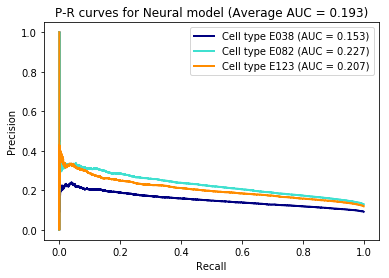

In [300]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue']) # , 'cornflowerblue', 'teal'
lines = []
labels = []
for i, color in zip(range(n_classes), colors):
    l, = plt.plot(rec[i], prec[i], color=color, lw=2)
    lines.append(l)
    labels.append('Cell type %s (AUC = %.3f)' %( test_type[i],pr_auc[i] ))

# i = 2
# plt.step(rec[i], prec[i], color='b', alpha=0.2,
#          where='post')
# plt.fill_between(rec[i], prec[i], step='post', alpha=0.2,
#                  color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
plt.title('P-R curves for Neural model (Average AUC = %.3f)' % (pr_auc['micro']))
plt.legend(lines, labels) # , loc=(0, -.38), prop=dict(size=14))

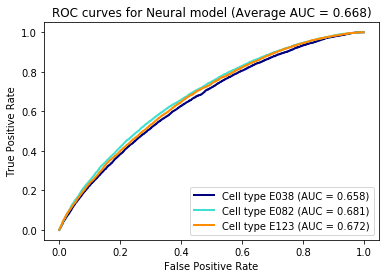

In [303]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue']) # , 'cornflowerblue', 'teal'
lines = []
labels = []
for i, color in zip(range(n_classes), colors):
    l, = plt.plot(fpr[i], tpr[i], color=color, lw=2)
    lines.append(l)
    labels.append('Cell type %s (AUC = %.3f)' %( test_type[i],roc_auc[i] ))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
plt.title('ROC curves for Neural model (Average AUC = %.3f)' % (roc_auc['micro']))
plt.legend(lines, labels) # , loc=(0, -.38), prop=dict(size=14))

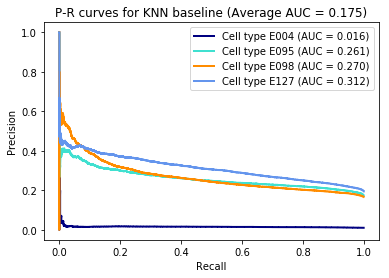

In [88]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue']) # , 'cornflowerblue', 'teal'
lines = []
labels = []
for i, color in zip(range(n_classes), colors):
    l, = plt.plot(knn_rec[i], knn_prec[i], color=color, lw=2)
    lines.append(l)
    labels.append('Cell type %s (AUC = %.3f)' %( valid_type[i],knn_pr_auc[i] ))

# i = 2
# plt.step(rec[i], prec[i], color='b', alpha=0.2,
#          where='post')
# plt.fill_between(rec[i], prec[i], step='post', alpha=0.2,
#                  color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
plt.title('P-R curves for KNN baseline (Average AUC = %.3f)' % (knn_pr_auc['micro']))
plt.legend(lines, labels) # , loc=(0, -.38), prop=dict(size=14))

In [85]:
## projection function with SVD
def PCA_project(X, modes, plot_SVs=True):
    # SVD of X
    U, s, VT = np.linalg.svd(X)
    # construct S matrix with S_vector -- there must be a better way to do this?
    S = np.zeros([U.shape[0],VT.shape[0]])
    for i in range(modes):
        S[i,i] = s[i]
#     print("shapes", X.shape, U.shape,S.shape,VT[:,:modes].shape, (U@S@VT[:,:modes]).shape)
    if plot_SVs:
        plt.plot(np.log(s))
        plt.show()
    return U@S@VT[:,:modes]

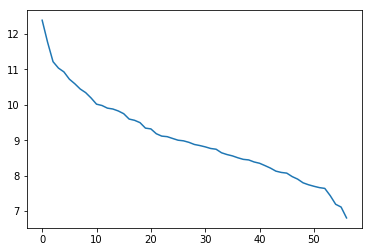

In [90]:
## Pick ONE!

# Linear PCA
trajectory_p = PCA_project(expn.transpose(),3)

# t-SNE
from sklearn.manifold import TSNE
trajectory_p = TSNE(n_components=3).fit_transform(expn.transpose()) # 57,19000 to 57,3
trajectory_p.shape

No handles with labels found to put in legend.


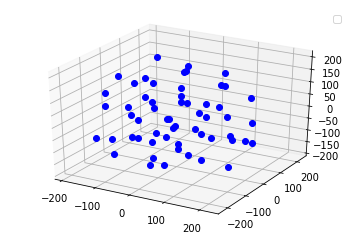

In [149]:
from mpl_toolkits.mplot3d import Axes3D
# mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
c=57
ax.plot(trajectory_p[:c,0],trajectory_p[:c,1],'bo',zs=trajectory_p[:c,2])
# ax.set_xlim(-.2,.2)
# ax.set_ylim(-.6,0)
# ax.set_zlim(.1,.5)
ax.legend()
plt.show()

In [114]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [126]:
x = pd.Series(trajectory_p[:,0])
y = pd.Series(trajectory_p[:,1])
z = pd.Series(trajectory_p[:,2])

fps = go.Scatter3d(x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.3
    ),
    text=expn.columns.tolist()
)
data = [fps]
fig = dict(data=data)
from plotly.graph_objs import *
plotly.offline.plot(fig, filename='testpca.html')#, height=700, validate=False)

'file:///n/data_01/cs287-s18/projects/testpca.html'

In [189]:
j=expn.iloc[:,0].values
j=np.sum(j**2)
j = np.sqrt(j)
expn.apply(np.linalg.norm,axis=0)
b[2,:10]
[expn.columns[i] for i in b[2,:10]]
a[2,:10]

8594.869900156953